In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [10]:
from models import ConvAutoEncoder

In [11]:
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0

In [12]:
def add_random_noise(batch):
    mask = np.random.uniform(0, 1, batch.shape)
    noise = np.random.randn(*batch.shape) * (mask >= 0.75).astype(np.float32)
    noisy_batch = batch + noise.astype(np.float32)
    noisy_batch = np.maximum(0, noisy_batch)
    noisy_batch = np.minimum(1, noisy_batch)
    return noisy_batch

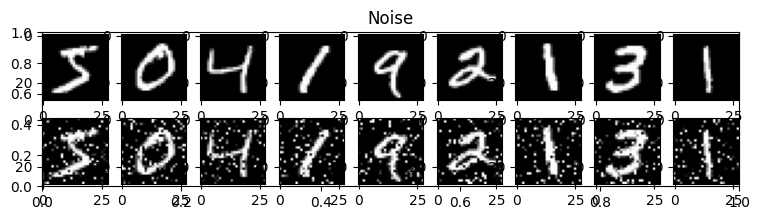

In [13]:
plt.figure(figsize=(9, 2))
plt.title("Noise")
plt.gray()
for i, img in enumerate(x_train[:9]):
    plt.subplot(2, 9, i+1)
    plt.imshow(img.reshape(28, 28))
for i, img in enumerate(x_train[:9]):
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(add_random_noise(img).reshape(28, 28))

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 4
BATCH_SIZE = 128
LEARNING_RATE = 0.002

# train a convolutional autoencoder on MNIST
mlp_model = ConvAutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()
inspections = []

for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS))
    epoch_loss = 0
    updates = 0

    for i in range(0, len(x_train), BATCH_SIZE):
        batch = x_train[i:i + BATCH_SIZE]

        # apply random noise to batch
        noisy_batch = add_random_noise(batch)

        batch = batch.reshape(-1, 1, 28, 28)
        batch = torch.from_numpy(batch).to(DEVICE)
        noisy_batch = noisy_batch.reshape(-1, 1, 28, 28)
        noisy_batch = torch.from_numpy(noisy_batch).to(DEVICE)

        # forward pass
        output = mlp_model(noisy_batch)
        loss = criterion(output, batch)

        epoch_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        updates += 1

        print(
            "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
            "loss: " + str(round(epoch_loss/((i + 1)*BATCH_SIZE), 5)), end="\r")

    print(
        "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
        "loss: " + str(round(epoch_loss/((i + 1)*BATCH_SIZE), 5)))

    if (epoch % 2 == 0 and len(inspections) < 4) or epoch == EPOCHS - 1:
        inspections.append((
            epoch, 
            noisy_batch.to("cpu").detach().numpy(), 
            output.to("cpu").detach().numpy()
        ))

Epoch: 1/4
update: 469/469 | loss: 0.005
Epoch: 2/4
update: 469/469 | loss: 0.012
Epoch: 3/4
update: 469/469 | loss: 0.0
Epoch: 4/4
update: 469/469 | loss: 0.0


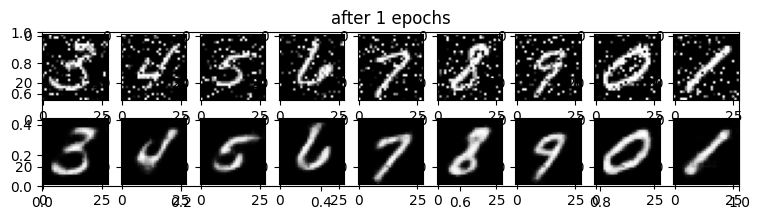

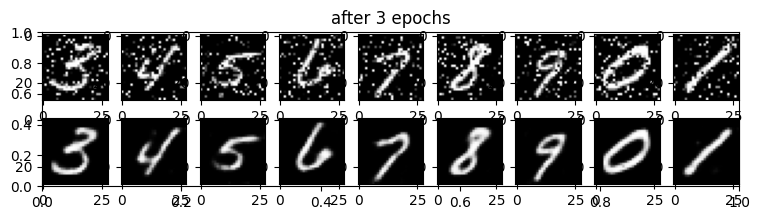

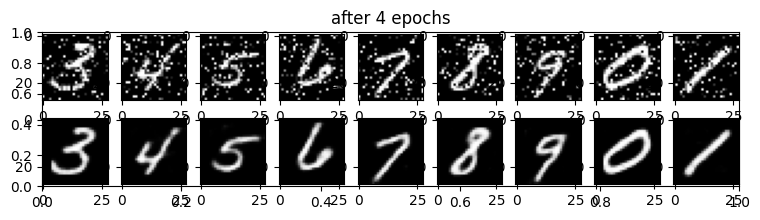

In [15]:
# examine how proficient the convolutional autoencoder is at reconstructing over epochs
for epoch, imgs, recons in inspections:
    plt.figure(figsize=(9, 2))
    plt.title("after " + str(epoch + 1) + " epochs")
    plt.gray()
    for i, img in enumerate(imgs[:9]):
        plt.subplot(2, 9, i+1)
        plt.imshow(img.reshape(28, 28))
    for i, recon in enumerate(recons[:9]):
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(recon.reshape(28, 28))